In [45]:
HOME_DIR = "/home_remote"
HOME = "/home/thi.tra.my.nguyen"

from liwc import Liwc
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize, ngrams
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
#import logisitic_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
relevant_features_name_without_Length ={'liwc': ['i', 'friend', 'sad', 'family', 'feel', 'health',
       'sexual', 'anx', 'body', 'bio', 'ppron', 'filler', 'shehe', 'adverb',
       'swear', 'humans', 'excl', 'assent', 'discrep', 'you', 'pronoun',
       'negemo', 'past'],
                        'liwc_alike': ['Anxiety', 'I', 'Sadness', 'Affective Processes',
       'Sexuality', 'Family', 'Friends', 'Fillers', 'Health', 'Feeling',
       'Humans', 'Biological Processes', 'Time', 'Body', 'Negative Emotions',
       'Social Processes', 'Perceptual Processes', 'Insight',
       'Cognitive Processes', 'Motion', 'Positive Emotions', 'Tentative',
       'Ppronouns']}

In [4]:
positives_df_path = os.path.join(HOME_DIR, "positive_df.pkl")
negatives_df_path = os.path.join(HOME_DIR, "negative_df.pkl")

positives = pd.read_pickle(positives_df_path)
negatives = pd.read_pickle(negatives_df_path)

In [5]:
def construct_liwc_input(df, label):
  """
  params: df - The positive/negative dataframe loaded from pickle
    The df is expected to has these columns "Title", "Date", "Text", "SubjectId"
  params: label - The label need to be assigned to result dataframe

  returns: A dataframe contains "SubjectId", "AverageLength", "Text", "NumOfWritings", "Title"
  """
  subject_id_list = df.loc[:, "TrainSubjectId"].unique()
  df["Token"] = df["Text"].apply(lambda x: word_tokenize(x))

  df['text'] = df['Text']+ df['Title']

  grouped_by_subject_id = df.groupby('TrainSubjectId')

  # calculate average token length for each user
  average_length_df = grouped_by_subject_id['Token'].apply(lambda token_series: sum(len(token) for token in token_series) / len(token_series)).reset_index()
  average_length_df.rename(columns={'Token': 'AverageLength'}, inplace=True)
  #print(average_length_df.head())

  # join all writings of single user into single corpus
  joined_text_df = grouped_by_subject_id['text'].apply(' '.join).reset_index()

  # calculate number of writings for each user
  number_of_writings_df = grouped_by_subject_id['Text'].apply(lambda x: len(x)).reset_index()
  number_of_writings_df.rename(columns={'Text': 'NumOfWritings'}, inplace=True)

  result_df = average_length_df.merge(joined_text_df, on="TrainSubjectId")
  result_df = result_df.merge(number_of_writings_df, on="TrainSubjectId")
  result_df["Label"] = label

  return result_df

In [6]:
# construct liwc input for positive and negative dataframe
input_positives = construct_liwc_input(positives, 1)
input_negatives = construct_liwc_input(negatives, 0)

In [7]:
#concatenate two dataframe and shuffle
liwc_input = pd.concat([input_positives, input_negatives])
liwc_input = liwc_input.sample(frac=1).reset_index(drop=True)

In [8]:
liwc_input

,TrainSubjectId,AverageLength,text,NumOfWritings,Label
0,train_subject7620,20.872093,"Three thumbs up ,that's a nice knife! I ...",1204,0
1,train_subject2071,17.365385,I'll drink to that! Just thought I'd add...,104,0
2,train_subject599,13.224510,Texans traveled to Oklahoma to wave Confede...,1991,0
3,train_subject522,23.300000,"The Postman Always Rings Twice. No postman, n...",20,0
4,train_subject4065,28.641960,Finally some sense. It's a travesty that lime...,796,0
...,...,...,...,...,...
481,train_subject8683,61.574368,http://en.wikipedia.org/wiki/Somnophilia\n\nI...,1701,1
482,train_subject4999,27.833333,ha thanks for the feedback i'm working on a p...,198,0
483,train_subject2252,31.130885,"Basically, you turned Bruce Wayne into Adam W...",1062,1
484,train_subject71,19.931481,Same with Kyle Busch. His is green and the re...,1080,0


### LIWC Features

In [9]:
# Load LIWC dictionary
liwc = Liwc(os.path.join(HOME_DIR, "master_thesis/LIWC2007_English100131.dic"))
input = [liwc.parse(word_tokenize(text)) for text in liwc_input['text']]

In [41]:
# Add AverageLength and NumOfWritings to the vector
def add_to_counter(counter, key, value):
    counter[key] = value
    return counter

# Get features
def get_features(df, output):
    df['vector'] = output
    average_length = df['AverageLength']
    num_of_writings = df['NumOfWritings']
    vector = df['vector']
    for i in range(len(vector)):
        vector[i] = add_to_counter(vector[i], "AverageLength", average_length[i])
        vector[i] = add_to_counter(vector[i], "NumOfWritings", num_of_writings[i])
    df['vector_added'] = vector
    vector_df = pd.DataFrame(df['vector_added'].tolist(), index=df.index)
    vector_df_norm = (vector_df - vector_df.min()) / (vector_df.max() - vector_df.min())
    vector_df_norm['Label'] = df['Label']
    vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']
    vector_df_norm = vector_df_norm.fillna(0)
    corr = vector_df_norm.corr()
    corr_label = corr['Label'].sort_values(ascending=False)
    relevant_features = corr_label[1:25]
    relevant_features_name = relevant_features.index.values
    X = vector_df_norm[relevant_features_name]
    y = vector_df_norm['Label']
    return X, y


In [42]:
X_liwc, y_liwc = get_features(liwc_input,input)

/tmp/ipykernel_131/3541103378.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector[i] = add_to_counter(vector[i], "AverageLength", average_length[i])
/tmp/ipykernel_131/3541103378.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector[i] = add_to_counter(vector[i], "NumOfWritings", num_of_writings[i])


### LIWC-alike

In [10]:
%run /home_remote/master_thesis/model_evaluation/liwc_alike.py

In [11]:
liwc_alike_output = [main(text, result) for text in liwc_input['text']]


In [275]:
X_liwc_alike, y_liwc_alike = get_features(liwc_input, liwc_alike_output)


/tmp/ipykernel_100870/3541103378.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector[i] = add_to_counter(vector[i], "AverageLength", average_length[i])
/tmp/ipykernel_100870/3541103378.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector[i] = add_to_counter(vector[i], "NumOfWritings", num_of_writings[i])


## Models

In [13]:
def logistic_regression(X, y):

    w = [1, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6,2**7, 2**8]
    weight = [{0: 1/(1+x),  1: x/(1+x)} for x in w]
    C = [2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 1, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6]
    # define grid search
    hyperparam_grid = {"class_weight": weight
                    ,"C": C
                    ,"fit_intercept": [True, False]  }
    # define evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    # define grid search
    model_test = LogisticRegression(solver='liblinear', penalty='l1')
    grid = GridSearchCV(estimator=model_test, param_grid=hyperparam_grid, cv=cv, scoring='f1')
    grid_result = grid.fit(X, y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    #build a model with the best parameters, fix class_weight = (0.2, 0.8)

    model = LogisticRegression(**grid_result.best_params_)
    model.fit(X, y)
    return model

In [371]:
mod = logistic_regression(X_liwc, y_liwc)
#cross_validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mod, X_liwc, y_liwc, cv=5, scoring='f1')
print(scores)

Best: 0.334819 using {'C': 16, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': True}
[0.25       0.07692308 0.         0.4375     0.28571429]


In [372]:
def random_forest(X, y):

    w = [1, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6,2**7, 2**8]
    weight = [{0: 1/(1+x),  1: x/(1+x)} for x in w]
    #C = [2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 1, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6]
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # define grid search
    hyperparam_grid = {"class_weight": weight,
                        'n_estimators': n_estimators,
                        'max_features': max_features,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'bootstrap': bootstrap}
    # define evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    # define grid search
    model_test = RandomForestClassifier()
    grid = GridSearchCV(estimator=model_test, param_grid=hyperparam_grid, cv=cv, scoring='f1')
    grid_result = grid.fit(X, y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    #build a model with the best parameters, fix class_weight = (0.2, 0.8)

    model = RandomForestClassifier(**grid_result.best_params_)
    model.fit(X, y)
    return model

In [29]:
#get extract
def extract_feature(df, output, type):
    # Assign the 'output' to a new column 'vector' in the DataFrame 'df'.
    df['vector'] = output
    
    # Create a new DataFrame 'vector_df' containing the 'vector' values, with the same index as 'df'.
    vector_df = pd.DataFrame(df['vector'].tolist(), index=df.index)
    #print(vector_df.head())
    vector_df = vector_df.fillna(0)
    #print(vector_df.head())
    # Normalize the values in 'vector_df' by dividing each row by the sum of its values.
    vector_df_norm = vector_df.div(vector_df.sum(axis=1), axis=0)

    # Assign 'Label' and 'TrainSubjectId' columns from 'df' to 'vector_df_norm'.
    vector_df_norm['Label'] = df['Label']
    vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']

    # Fill any NaN (Not-a-Number) values with 0.
    #vector_df_norm = vector_df_norm.fillna(0)

    # Create feature matrix 'X' from the relevant features based on 'type'.
    X = vector_df_norm[relevant_features_name_without_Length[type]]

    # Create the target variable 'y' from the 'Label' column in 'vector_df_norm'.
    y = vector_df_norm['Label']

    # Return the feature matrix 'X' and the target variable 'y'.
    return X, y


In [ ]:
def extract_feature_minmax(df, output, type):
    # Assign the 'output' to a new column 'vector' in the DataFrame 'df'.
    df['vector'] = output
    
    # Create a new DataFrame 'vector_df' containing the 'vector' values, with the same index as 'df'.
    vector_df = pd.DataFrame(df['vector'].tolist(), index=df.index)
    #print(vector_df.head())
    vector_df = vector_df.fillna(0)
    #print(vector_df.head())
    # Normalize the values in 'vector_df' by dividing each row by the sum of its values.
    vector_df_norm = (vector_df - vector_df.min()) / (vector_df.max() - vector_df.min())

    # Assign 'Label' and 'TrainSubjectId' columns from 'df' to 'vector_df_norm'.
    vector_df_norm['Label'] = df['Label']
    vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']

    # Fill any NaN (Not-a-Number) values with 0.
    #vector_df_norm = vector_df_norm.fillna(0)

    # Create feature matrix 'X' from the relevant features based on 'type'.
    X = vector_df_norm[relevant_features_name_without_Length[type]]

    # Create the target variable 'y' from the 'Label' column in 'vector_df_norm'.
    y = vector_df_norm['Label']

    # Return the feature matrix 'X' and the target variable 'y'.
    return X, y

In [12]:
data_input = liwc_input[['TrainSubjectId', 'Label', 'text']]

In [30]:
X_liwc_alike2, y_liwc_alike2 = extract_feature(data_input, liwc_alike_output, 'liwc_alike')

/tmp/ipykernel_131/4268587586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vector'] = output


In [34]:
mod = logistic_regression(X_liwc_alike2, y_liwc_alike2)
#cross_validation
scores = cross_val_score(mod, X_liwc_alike2, y_liwc_alike2, cv=5, scoring='f1')
print(scores)

Best: 0.613579 using {'C': 32, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': True}
[0.11111111 0.         0.11764706 0.         0.21052632]


In [35]:
X_liwc_alike2

,Anxiety,I,Sadness,Affective Processes,Sexuality,Family,Friends,Fillers,Health,Feeling,...,Body,Negative Emotions,Social Processes,Perceptual Processes,Insight,Cognitive Processes,Motion,Positive Emotions,Tentative,Ppronouns
0,0.000336,0.012380,0.000336,0.001443,0.002181,0.003858,0.003858,0.000168,0.001074,0.006878,...,0.003187,0.004932,0.026942,0.014125,0.017749,0.013052,0.013790,0.020466,0.017480,0.055460
1,0.000000,0.013616,0.000400,0.001602,0.000801,0.004806,0.002403,0.000000,0.000000,0.005607,...,0.002403,0.004005,0.029636,0.008811,0.024029,0.018823,0.018422,0.012415,0.014017,0.061274
2,0.000256,0.005173,0.000313,0.001393,0.001620,0.001819,0.001705,0.000085,0.001848,0.006481,...,0.002700,0.003894,0.026292,0.012847,0.017850,0.014041,0.012023,0.011995,0.020181,0.039395
3,0.000000,0.007782,0.001946,0.000000,0.001946,0.000000,0.000000,0.000000,0.000000,0.007782,...,0.000000,0.007782,0.015564,0.013619,0.019455,0.015564,0.005837,0.011673,0.017510,0.042802
4,0.000371,0.007357,0.000371,0.001890,0.000574,0.000742,0.001654,0.000202,0.001654,0.007255,...,0.001687,0.003813,0.029663,0.016569,0.023656,0.017244,0.013161,0.018122,0.024567,0.052239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,0.000990,0.010238,0.000886,0.001869,0.001447,0.001461,0.001440,0.000035,0.003087,0.008327,...,0.001724,0.004735,0.031717,0.017202,0.024380,0.018974,0.013380,0.012453,0.027896,0.052498
482,0.000170,0.008851,0.000000,0.000681,0.000511,0.001021,0.001702,0.000340,0.000681,0.006809,...,0.002213,0.006638,0.029957,0.011574,0.017532,0.013957,0.019404,0.016681,0.021957,0.048511
483,0.000482,0.013825,0.000120,0.001301,0.001036,0.002144,0.003203,0.000145,0.002433,0.009032,...,0.002071,0.003926,0.032203,0.014090,0.020232,0.015198,0.013560,0.014114,0.027362,0.050701
484,0.000304,0.007867,0.000236,0.001080,0.001080,0.002364,0.002735,0.000000,0.001384,0.006618,...,0.002803,0.002971,0.028599,0.014452,0.019314,0.015498,0.013506,0.015937,0.021070,0.056388


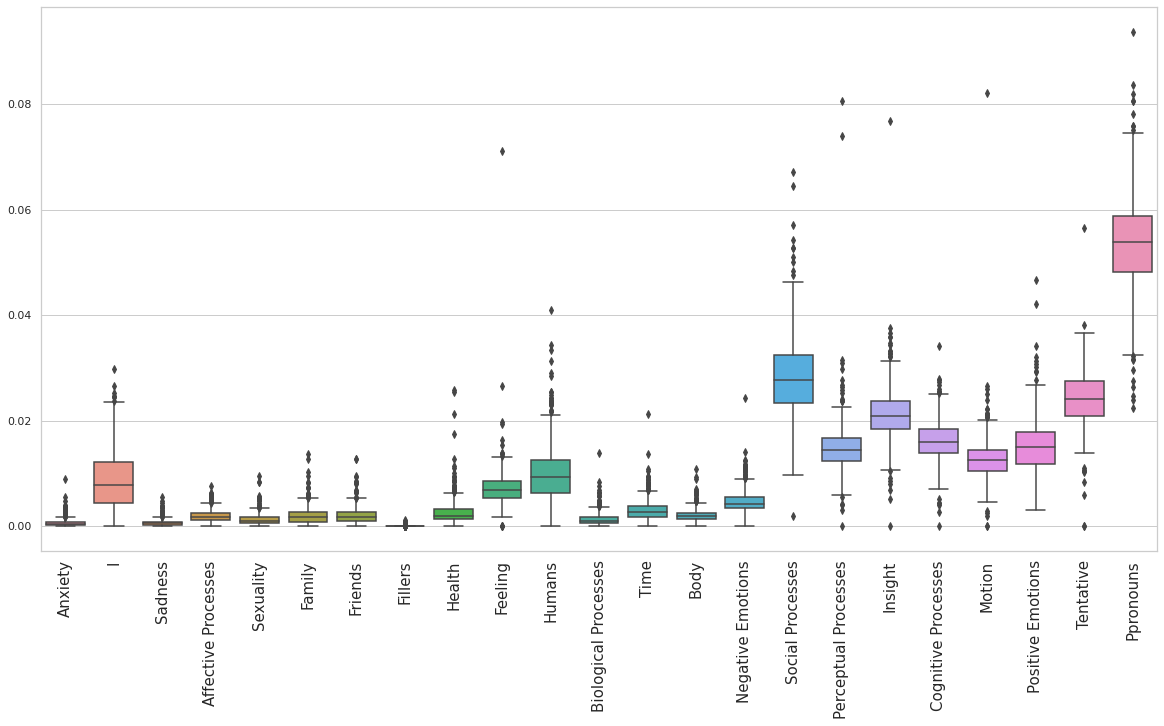

In [123]:
#visualize the vector
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=X_liwc_alike2)
plt.xticks(rotation=90)
#change size of tick labels
plt.tick_params(axis='x', which='major', labelsize=15)
plt.savefig(os.path.join(HOME_DIR,'boxplot_liwc_alike.pdf'), bbox_inches = 'tight')

In [38]:
X_liwc2, y_liwc2 = extract_feature(data_input, input, 'liwc')

/tmp/ipykernel_131/4268587586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vector'] = output


In [39]:
X_liwc2

,i,friend,sad,family,feel,health,sexual,anx,body,bio,...,adverb,swear,humans,excl,assent,discrep,you,pronoun,negemo,past
0,0.006877,0.000500,0.000880,0.002159,0.003719,0.001779,0.002699,0.000840,0.004358,0.011536,...,0.016274,0.003239,0.004838,0.009676,0.001180,0.005158,0.007137,0.042864,0.008357,0.013295
1,0.008132,0.000525,0.001312,0.001574,0.001312,0.001312,0.000787,0.000787,0.002623,0.007870,...,0.013379,0.000525,0.003673,0.005247,0.000525,0.009444,0.004460,0.047482,0.004460,0.017314
2,0.002801,0.000682,0.001382,0.001142,0.001382,0.001621,0.001253,0.000848,0.001677,0.005786,...,0.018628,0.000774,0.003611,0.009471,0.000424,0.004956,0.002414,0.036095,0.007536,0.017099
3,0.005495,0.000000,0.002747,0.000000,0.000000,0.000000,0.002747,0.001374,0.000000,0.002747,...,0.015110,0.000000,0.001374,0.006868,0.000000,0.004121,0.001374,0.038462,0.008242,0.023352
4,0.004695,0.000358,0.001319,0.000581,0.002392,0.002191,0.001274,0.000760,0.002191,0.006930,...,0.019159,0.001721,0.002571,0.013704,0.000693,0.008495,0.006930,0.044979,0.008495,0.012854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,0.006157,0.000542,0.001975,0.000714,0.002689,0.002631,0.001366,0.001459,0.002772,0.007559,...,0.020063,0.000978,0.003724,0.013548,0.000591,0.008136,0.006298,0.046644,0.009745,0.012200
482,0.006492,0.000649,0.001190,0.000216,0.002489,0.001082,0.001082,0.001407,0.003679,0.006492,...,0.019152,0.002056,0.004220,0.010604,0.002272,0.005735,0.007033,0.040684,0.011469,0.012010
483,0.007906,0.001258,0.001081,0.000977,0.002398,0.003568,0.001895,0.000799,0.002739,0.011636,...,0.018624,0.001821,0.002961,0.012406,0.000785,0.007920,0.004116,0.041601,0.007802,0.015071
484,0.004904,0.000622,0.001105,0.001266,0.001681,0.001450,0.001796,0.000645,0.003315,0.009186,...,0.019269,0.002786,0.002509,0.011833,0.001082,0.006377,0.006837,0.048553,0.007390,0.016691


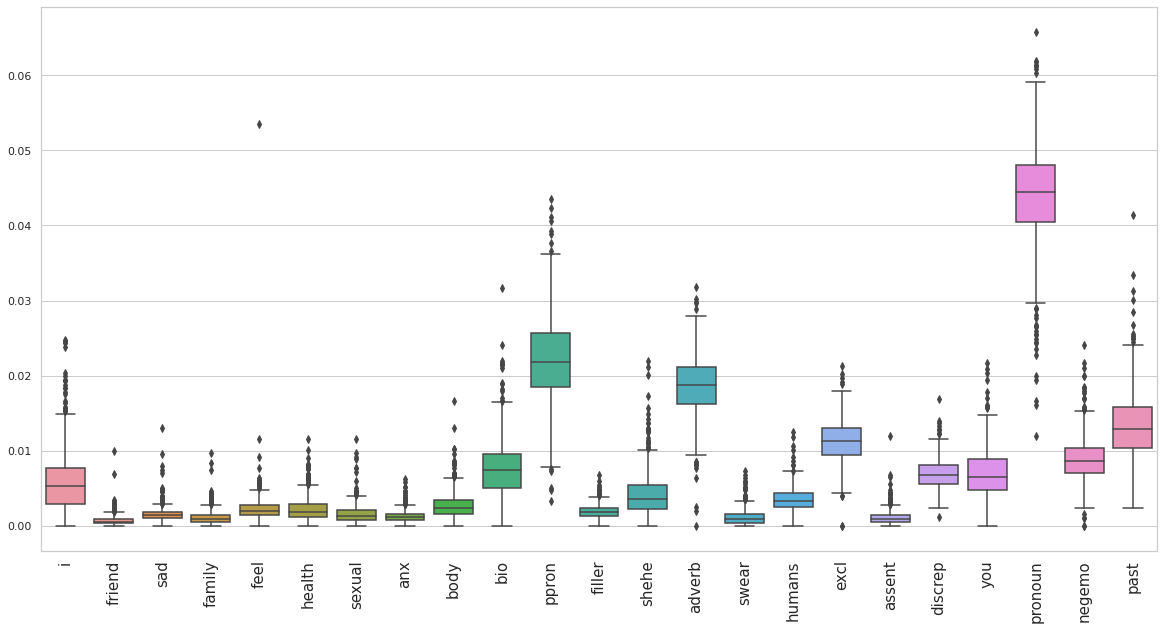

In [122]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=X_liwc2)
plt.xticks(rotation=90)
#change size of tick labels
plt.tick_params(axis='x', which='major', labelsize=15)
plt.savefig(os.path.join(HOME_DIR,'boxplot_liwc.pdf'))

### Smooth vectors

In [44]:
from scipy.signal import savgol_filter

In [138]:
#using Savitzky-Golay filter to smooth the data
X_liwc_alike2_filter= savgol_filter(X_liwc_alike2, window_length=4, polyorder=3, deriv=2)

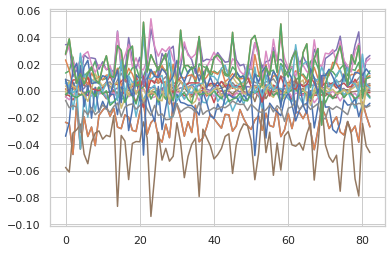

In [129]:
#get the corresponding X 
index = np.where(y_liwc_alike2 == 1)
plt.plot(X_liwc_alike2_filter[index])
plt.show()

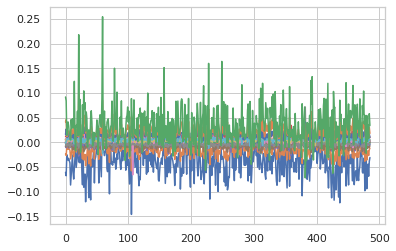

In [141]:
plt.Figure(figsize=(40,20))
plt.plot(X_liwc_alike2_filter)
plt.show()

In [139]:
mod = logistic_regression(X_liwc_alike2_filter, y_liwc_alike2)
#cross_validation
scores = cross_val_score(mod, X_liwc_alike2_filter, y_liwc_alike2, cv=5, scoring='f1')
print(scores)

Best: 0.544632 using {'C': 64, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': True}
[0.46153846 0.51428571 0.47619048 0.41176471 0.48979592]


In [140]:
joblib.dump(mod, os.path.join(HOME_DIR,'liwc_alike_filter.plk'))

['/home_remote/liwc_alike_filter.plk']

#### LSTM